In [1]:
# standard library imports
import gc
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# third party imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import polars as pl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    log_loss,
    SCORERS, 
    get_scorer,
    classification_report, 
    ConfusionMatrixDisplay, 
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC

# will probably need these later:

# import torch
# from adapters import AutoAdapterModel
# from joblib import dump, load
# from pytorch_lightning import Trainer, LightningModule

# from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm
# from transformers import (
#     AdamW, 
#     AutoTokenizer, 
#     RobertaForSequenceClassification, 
#     get_linear_schedule_with_warmup
# )

dataPath = ""

In [2]:
df = pd.read_csv("csv_files/train/train_base.csv")

In [3]:
df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [4]:
# simple trained and fit model used just to make sure report works

X_train, y_train = df.drop(columns=["target"]), df["target"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,  X_train.select_dtypes(exclude="object").columns),
        ('cat', categorical_transformer,  X_train.select_dtypes(include="object").columns)])

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("clf", LogisticRegression(random_state=0, max_iter=1000)),
    ]
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_train)

In [6]:
def generate_report(mdl, df, cols, extra_metrics=None):
    '''Takes in a [what kind?] model as a string, pandas dataframe of a subset of the test data, 
    and list of columns to be used in the model.
    If necessary, can include a list of other metrics to be outputted, but default is None.
    Returns a dictionary of the following breakdown of scores: AUC, F1-Score, and any extra metrics
    '''
    # Load in a model we have trained and saved somewhere else in the repo
#     model = load(os.path.join(MODELS_DIR, mdl))

    # for now, we will be using a model trained in the notebook
    model = mdl
    X_test, y_test = df[cols], df["target"]
    y_pred = model.predict(X_test)
    
    res = dict()
    res['AUC'] = roc_auc_score(y_test, y_pred)
    res['Macro F-1'] = f1_score(y_test, y_pred, average='macro')
        
    for metric in extra_metrics:
        if metric == 'log_loss':
            res[metric] = log_loss(y_test, y_pred)
            print(f"Log Loss: {log_loss(y_test, y_pred)}")
        else:
            res[metric] = get_scorer(metric)._score_func(y_test, y_pred)
#         metric_func = getattr(locals()['__builtins__'], metric)
            print(f"{metric}: {get_scorer(metric)._score_func(y_test, y_pred)}")
        

    # Results
#     print(roc_auc_score(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    print(f"Macro-Averaged F1-Score: {f1_score(y_test, y_pred, average='macro')}")

    disp1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
    disp2 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="pred")
        
    return res

Log Loss: 1.0858050385170126
AUC: 0.5
Macro-Averaged F1-Score: 0.4920151704109108


{'AUC': 0.5, 'Macro F-1': 0.4920151704109108, 'log_loss': 1.0858050385170126}

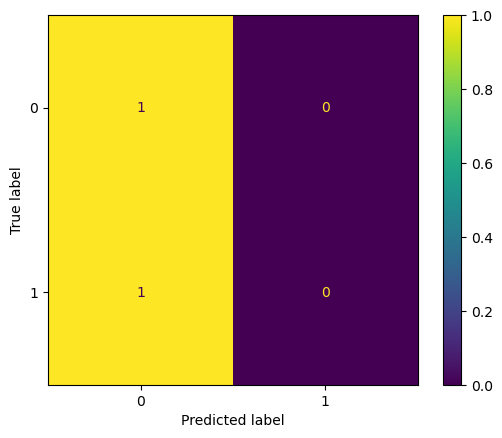

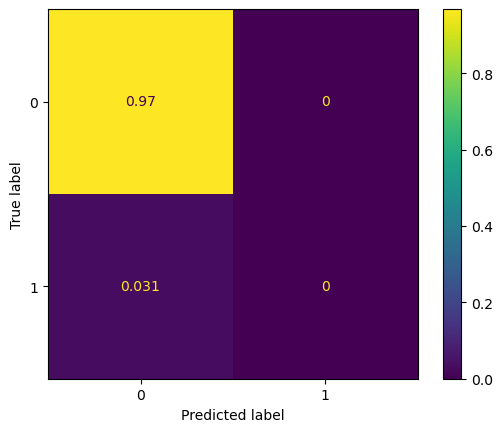

In [7]:
generate_report(pipe, df, ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM'], ['log_loss'])